In [1]:
import numpy as np
import random
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.layers import Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
class ResNetModel:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.model = self.build_model()

    def build_model(self):
        inputs = Input(shape=self.input_shape)

        x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

        filters = [64, 128, 256, 512]
        num_blocks = [2, 2, 2, 2]

        for i in range(len(filters)):
            for j in range(num_blocks[i]):
                if j == 0 and i != 0:
                    x = self.residual_block(x, filters[i], stride=2)
                else:
                    x = self.residual_block(x, filters[i])

        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Flatten()(x)

        model = models.Model(inputs, x)
        return model

    def residual_block(self, x, filters, kernel_size=3, stride=1, activation='relu'):
        shortcut = x

        x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)

        x = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
        x = layers.BatchNormalization()(x)

        if stride != 1 or shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        x = layers.add([x, shortcut])
        x = layers.Activation(activation)(x)

        return x

In [4]:
def euclidean_distance(vectors):
    x, y = vectors
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

def contrastive_loss(y_true, y_pred, margin=1):
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)

In [8]:
class SiameseNetwork:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.base_network = ResNetModel(input_shape).model
        self.model = self.build_model()

    def build_model(self):
        input_a = Input(shape=self.input_shape)
        input_b = Input(shape=self.input_shape)

        processed_a = self.base_network(input_a)
        processed_b = self.base_network(input_b)

        distance = layers.Lambda(euclidean_distance)([processed_a, processed_b])

        model = Model(inputs=[input_a, input_b], outputs=distance)
        return model

    def compile_model(self, optimizer='adam'):
        self.model.compile(loss=contrastive_loss, optimizer=optimizer)

    def train_on_batch(self, batch_pairs, batch_labels):
        return self.model.train_on_batch([batch_pairs[:, 0], batch_pairs[:, 1]], batch_labels)

    def predict(self, X):
        return self.model.predict(X)

    def save_model(self, filepath):
        return self.model.save(filepath)
    
    def load_weights(self, filepath):
        return self.model.load_weights(filepath)


In [6]:
def create_pairs(X, digit_indices):
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(len(digit_indices))]) - 1
    for d in range(len(digit_indices)):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[X[z1], X[z2]]]
            inc = random.randrange(1, len(digit_indices))
            dn = (d + inc) % len(digit_indices)
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[X[z1], X[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


In [7]:
def load_and_preprocess_mnist():
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    X_train = np.expand_dims(X_train, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)
    y_train = to_categorical(y_train, num_classes=10)
    y_test = to_categorical(y_test, num_classes=10)
    return (X_train, y_train), (X_test, y_test)


In [8]:
# Example usage
(X_train, y_train), (X_test, y_test) = load_and_preprocess_mnist()
input_shape = (28, 28, 1)
siamese_net = SiameseNetwork(input_shape)
siamese_net.compile_model(optimizer=Adam())

# Create pairs for training
digit_indices = [np.where(y_train.argmax(axis=1) == i)[0] for i in range(10)]
pairs, labels = create_pairs(X_train, digit_indices)


In [9]:
# Custom training loop using train_on_batch
batch_size = 64
epochs = 10
num_batches = len(pairs) // batch_size

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for batch in range(num_batches):
        batch_pairs = pairs[batch * batch_size:(batch + 1) * batch_size]
        batch_labels = labels[batch * batch_size:(batch + 1) * batch_size]
        loss = siamese_net.train_on_batch(batch_pairs, batch_labels)
        if batch % 100 == 0:
            print(f"Batch {batch}/{num_batches} - Loss: {loss:.4f}")

siamese_net.save_model('siamese_resnet.h5')

Epoch 1/10
Batch 0/1693 - Loss: 484.7462
Batch 100/1693 - Loss: 3.9023
Batch 200/1693 - Loss: 2.7523
Batch 300/1693 - Loss: 1.4224
Batch 400/1693 - Loss: 0.4319
Batch 500/1693 - Loss: 0.8143
Batch 600/1693 - Loss: 0.3894
Batch 700/1693 - Loss: 0.7779
Batch 800/1693 - Loss: 0.7772
Batch 900/1693 - Loss: 0.2780
Batch 1000/1693 - Loss: 0.2374
Batch 1100/1693 - Loss: 0.2450
Batch 1200/1693 - Loss: 0.5232
Batch 1300/1693 - Loss: 0.2005
Batch 1400/1693 - Loss: 0.3626
Batch 1500/1693 - Loss: 0.1763
Batch 1600/1693 - Loss: 0.2156
Epoch 2/10
Batch 0/1693 - Loss: 0.4415
Batch 100/1693 - Loss: 0.1896
Batch 200/1693 - Loss: 0.1501
Batch 300/1693 - Loss: 0.0999
Batch 400/1693 - Loss: 0.2479
Batch 500/1693 - Loss: 0.1675
Batch 600/1693 - Loss: 0.2305
Batch 700/1693 - Loss: 0.2696
Batch 800/1693 - Loss: 0.0973
Batch 900/1693 - Loss: 0.2901
Batch 1000/1693 - Loss: 0.1845
Batch 1100/1693 - Loss: 0.1194
Batch 1200/1693 - Loss: 0.2583
Batch 1300/1693 - Loss: 0.1024
Batch 1400/1693 - Loss: 0.1491
Batch 15

In [10]:
# Create folders to save the results
similar_folder = "similar_results"
dissimilar_folder = "dissimilar_results"
for folder in [similar_folder, dissimilar_folder]:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [11]:
# Initialize counters for pairs in each folder
similar_count = 0
dissimilar_count = 0

# Iterate over the test set to find similar and dissimilar pairs
for i in range(len(X_test)):
    for j in range(i + 1, len(X_test)):
        image1 = X_test[i]
        image2 = X_test[j]

        # Determine if the images are similar or dissimilar based on labels
        if np.argmax(y_test[i]) == np.argmax(y_test[j]):
            folder = similar_folder
            similar_count += 1
        else:
            folder = dissimilar_folder
            dissimilar_count += 1

        # If both folders have reached 100 pairs, stop the loop
        if similar_count == 100 and dissimilar_count == 100:
            break

        # Expand dimensions to match the input shape of (28, 28, 1)
        image1_expanded = np.expand_dims(image1, axis=0)
        image2_expanded = np.expand_dims(image2, axis=0)

        # Predict the distance between the two images
        distance = siamese_net.predict([image1_expanded, image2_expanded])[0][0]

        # Plot the images
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(image1.squeeze(), cmap='gray')
        plt.title('Image 1')

        plt.subplot(1, 2, 2)
        plt.imshow(image2.squeeze(), cmap='gray')
        plt.title('Image 2')

        plt.suptitle(f'Distance: {distance:.4f}', fontsize=16)

        # Save the figure
        plt.savefig(os.path.join(folder, f'result_{folder}_{similar_count if folder == similar_folder else dissimilar_count}.png'))
        plt.close()

    # Break the outer loop if both folders have reached 100 pairs
    if similar_count == 100 and dissimilar_count == 100:
        break

1/1 [==============================] - 0s 50ms/step


KeyboardInterrupt: 

1/1 [==============================] - 0s 34ms/step
Distance between the two images: [[0.504422]]


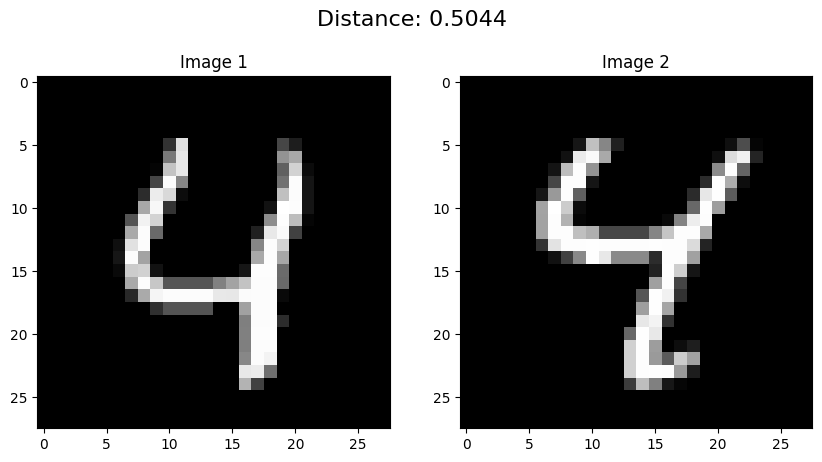

In [ ]:
# Choose two images from the test set
image1 = X_test[4]  # Example image 1
image2 = X_test[6]  # Example image 2


# Expand dimensions to match the input shape of (28, 28, 1)
image1 = np.expand_dims(image1, axis=0)
image2 = np.expand_dims(image2, axis=0)


# Predict the distance between the two images
distance = siamese_net.predict([image1, image2])

# Print the distance
print("Distance between the two images:", distance)

# Plot the images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image1.squeeze(), cmap='gray')
plt.title('Image 1')

plt.subplot(1, 2, 2)
plt.imshow(image2.squeeze(), cmap='gray')
plt.title('Image 2')

plt.suptitle(f'Distance: {distance[0][0]:.4f}', fontsize=16)
plt.show()

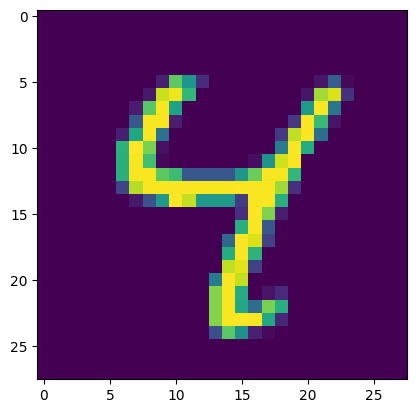

In [ ]:
plt.imshow(X_test[6])

In [9]:
input_shape = (28, 28, 1)
net = SiameseNetwork(input_shape)

In [10]:
net.load_weights('siamese_resnet.h5')